<a href="https://colab.research.google.com/github/Abenezer133/Student-Dropout-Model/blob/main/student_dropout_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LogReg F1: 0.5
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.50      0.50      0.50         4

    accuracy                           0.89        35
   macro avg       0.72      0.72      0.72        35
weighted avg       0.89      0.89      0.89        35

XGB F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00         4

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35

Precision@top10%: 1.000 (true positives 3 / 3)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:10:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-279703890.py:60: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, show=True)


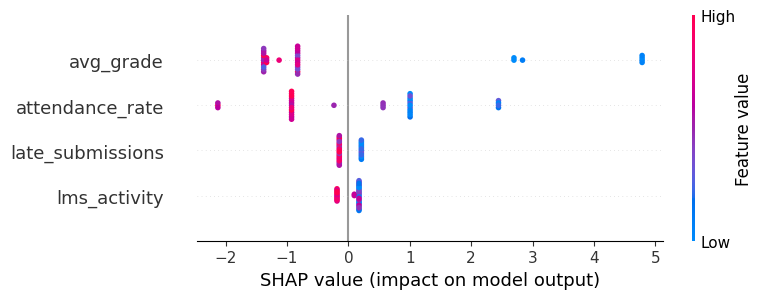

Example features:
 {'attendance_rate': 0.7553736512887829, 'avg_grade': 86.30456668613309, 'late_submissions': 5, 'lms_activity': 0.7482596903836584}
Predicted dropout risk (probability): 0.002


In [1]:
!pip install -q pandas scikit-learn xgboost shap joblib
import pandas as pd
import numpy as np
np.random.seed(42)

# Simulate 175 students with simple features
data = pd.DataFrame({
    "attendance_rate": np.random.uniform(0.5, 1.0, 175),  # 0.5 to 1.0
    "avg_grade": np.random.uniform(50, 100, 175),         # numeric grade
    "late_submissions": np.random.randint(0, 10, 175),    # count
    "lms_activity": np.random.uniform(0, 1, 175),         # engagement score
})

# create label: at risk if attendance < 0.75 AND avg_grade < 60
data["dropout"] = ((data["attendance_rate"] < 0.75) & (data["avg_grade"] < 60)).astype(int)

# Quick check
data.head(), data['dropout'].mean()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier

# features/target
X = data.drop(columns=['dropout'])
y = data['dropout']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# baseline: logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("LogReg F1:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGB F1:", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# precision @ top 10%
import numpy as np
probs = xgb.predict_proba(X_test)[:,1]
k = max(1, int(0.10 * len(probs)))
top_idx = np.argsort(probs)[-k:]
precision_top10 = y_test.iloc[top_idx].sum() / k
print(f"Precision@top10%: {precision_top10:.3f} (true positives {y_test.iloc[top_idx].sum()} / {k})")
import shap
import matplotlib.pyplot as plt

# explain XGBoost model with SHAP
explainer = shap.Explainer(xgb, X_train)   # simpler, robust API
shap_values = explainer(X_test)

# summary plot (displays inline in Colab)
shap.summary_plot(shap_values.values, X_test, show=True)
# Pick a single student from test set and show predicted risk
example = X_test.iloc[0:1]
proba = xgb.predict_proba(example)[:,1][0]
print("Example features:\n", example.to_dict(orient='records')[0])
print(f"Predicted dropout risk (probability): {proba:.3f}")

